In [120]:
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import rubin_sim.maf as maf

In [2]:
opsdb = 'too_elab_heavy_r128_d2_griz_v3.4_10yrs.db'
run_name = opsdb.replace('.db.', '')

In [159]:
# Just check in on the "note" so we can identify too observations and what those observations look like
conn = sqlite3.connect(opsdb)
query = "select observationStartMJD, filter, fieldRA, fieldDec, rotSkyPos, note from observations"
query += " where note like '%ToO%'"
df = pd.read_sql(query, conn)

def map_too(x):
    if x['note'].startswith('ToO'):
        return x['note'].split('_')[0].replace(',','')
    else:
        return ''
too_trigger = df.apply(map_too, axis=1)

df['too_trigger'] = too_trigger
len(df.too_trigger.unique())  # note that with non-ToO visits, there is one additional '' value

430

In [199]:
# First guess .. New stacker to make simpler note name to group ToOs by event

# Rerun cell if needed
try:
    del maf.BaseStacker.registry['__main__.ToOEventStacker']
except KeyError:
    pass


class ToOEventStacker(maf.BaseStacker):
    """Add a tag to each visit that corresponds to a too trigger,
    identifying the visit as belonging to that trigger event.

    The action of the stacker is to add a new column to the 
    observation data, `too_trigger`, which splits the expected 
    `note` information of something like "ToO, 0_t1" into "ToO 0" 
    (where "0" corresponds to the particular trigger and in the original
    note, "t1" was the first round of ToO observations, etc.).

    Parameters
    ----------
    note_col : `str`, optional
        The name of the column containing the "note" information.
    """

    cols_added = ['too_trigger']

    def __init__(self, note_col="note"):
        self.note_col = note_col
        self.cols_req = [self.note_col]
        self.cols_added_dtypes = [(str, 15)]
        self.units = ['']

    @staticmethod
    def map_too_note(x):
        if x['note'].startswith('ToO'):
            return x['note'].split('_')[0].replace(',','')
        else:
            return ''
            
    def _run(self, sim_data, cols_present=False):
        if cols_present:
            # Column already present in data; assume it is correct and does not need recalculating.
            return sim_data
        df = pd.DataFrame(sim_data)
        too_trigger = df.apply(self.map_too_note, axis=1)
        print(len(df), len(sim_data), len(too_trigger.values))
        sim_data['too_trigger'] = too_trigger.values
        return sim_data

In [58]:
# test stacker
simdata = maf.get_sim_data(opsdb, None, ['observationStartMJD', 'filter', 'fieldRA', 'fieldDec', 'rotSkyPos', 'note'], 
                          stackers=[ToOEventStacker()])

In [152]:
len(np.unique(simdata['too_trigger']))

431

In [146]:
def generate_too_slicer(events=events, n_files=100, d_min=10, d_max=300,seed=42):
    """Generate a slicer that includes the ToO trigger event information. 

    Parameters
    ----------
    events : `np.Ndarray`, `(N,)`
       Numpy recarray containing the too trigger information 
       (typically from the opsdb.events table).
    seed : `float`
        The seed passed to np.random.default_rng.
    n_files : `int`
        The number of different kilonova lightcurves to use.
    d_min : `float` or `int`
        Minimum luminosity distance (Mpc).
    d_max : `float` or `int`
        Maximum luminosity distance (Mpc).
    """
    rng = np.random.default_rng(seed=seed)
    n_events = len(events)
    # Let's just assign the peak time to the time of the trigger
    peak_times = events['mjd_start']
    # We can still have random types of KNes
    file_indx = np.floor(rng.uniform(low=0, high=n_files, size=n_events)).astype(int)
    # and random distances
    def rndm(a, b, g, size=1):
        """Power-law gen for pdf(x) proportional to x^{g-1} for a<=x<=b"""
        r = rng.random(size=size)
        ag, bg = a**g, b**g
        return (ag + (bg - ag) * r) ** (1.0 / g)
    distance = rndm(d_min, d_max, 4, size=n_events)

    # Set up the slicer to evaluate the catalog we just made
    slicer = maf.slicers.UserPointsSlicer(np.degrees(events['ra']), np.degrees(events['dec']), lat_lon_deg=True, badval=0)
    # Add any additional information about each object to the slicer
    slicer.slice_points["too_trigger"] = events['too_event']
    slicer.slice_points["peak_time"] = peak_times
    slicer.slice_points["file_indx"] = file_indx
    slicer.slice_points["distance"] = distance
    return slicer


events = pd.read_sql('select * from events', conn)
events.rename({'index':'too_event'}, axis=1, inplace=True)
events = events.to_records()
print(len(events))

slicer = generate_too_slicer(events)


1280


In [90]:
# Great, now let's run the presto color metric on the ToO events. 
# We need to modify the slicer, so that instead of setting off events at random, it matches the ToO triggers

# Note mjd0 value=0 here .. this is important because t_start/t_end in *slicer* is used to set 'tpeak' in days.
# To sync those *days* and the *actual day*, mjd0 does a translation. 
# tpeak is just be set as an actual mjd to avoid this.

metric = maf.PrestoColorKNePopMetric(
        metric_name="KNePopMetric_ToO",
        mjd_col="observationStartMJD",
        m5_col="fiveSigmaDepth",
        filter_col="filter",
        night_col="night",
        pts_needed=2,
        file_list=None,
        mjd0=0,
        output_lc=False,
        skyregion="extragalactic",
        thr=0.003)

constraint = "note like '%ToO%'"

bundle = maf.MetricBundle(metric, slicer, constraint, run_name=run_name)

In [91]:
g = maf.MetricBundleGroup({"too": bundle}, opsdb)
g.run_all()

In [126]:
# If you accidentally overwrite one of score_s or score_p ... sigh ..
g.bundle_dict = {'too': bundle}
g.reduce_all() 

In [96]:
g.bundle_dict

{'too': <rubin_sim.maf.metric_bundles.metric_bundle.MetricBundle at 0x1b1215d90>,
 'KNePopMetric_ToO_presto_color_detect': <rubin_sim.maf.metric_bundles.metric_bundle.MetricBundle at 0x1b163fe90>,
 'KNePopMetric_ToO_score_p': <rubin_sim.maf.metric_bundles.metric_bundle.MetricBundle at 0x1b16565d0>,
 'KNePopMetric_ToO_score_s': <rubin_sim.maf.metric_bundles.metric_bundle.MetricBundle at 0x1a3e2fc90>}

In [117]:
# So which one was which again? 
# score_s looks like the metric which is 0 or 1, depending on whether the probability hits the threshold
score_s = g.bundle_dict['KNePopMetric_ToO_score_s']

140.0 too triggers hit the required threshold


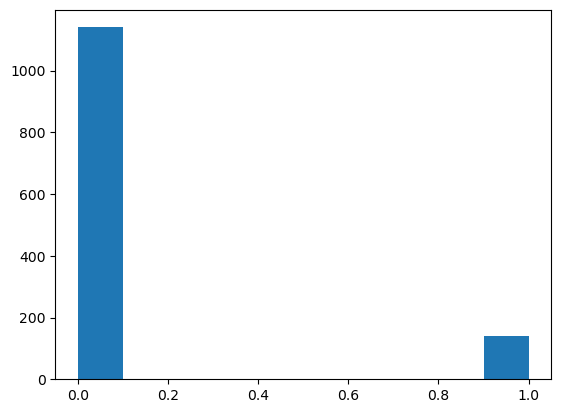

In [166]:
print(f"{score_s.metric_values.sum()} too triggers hit the required threshold")
_ = plt.hist(score_s.metric_values, bins=10)

(array([1.071e+03, 1.400e+01, 0.000e+00, 2.000e+00, 1.000e+01, 4.000e+00,
        0.000e+00, 8.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 0.000e+00,
        2.000e+00, 6.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.400e+02]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

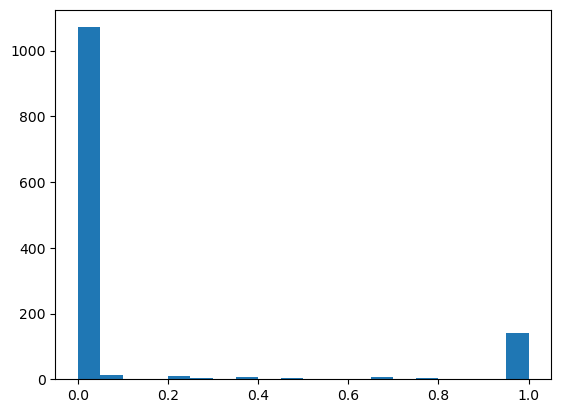

In [167]:
# So score_p is the probability of being able to distinguish a KNe from the background in each trigger
score_p = copy.deepcopy(g.bundle_dict['KNePopMetric_ToO_score_p'])a
plt.hist(score_p.metric_values, bins=20)

In [169]:
# Here is where I am confused ... 
# why is the metric reporting non-bad values (even if they're 0) 
# for some of these triggers where there could not have been observations?
# (above shows only 430 out of the 1280 triggers were actually observed in the simdata).

# Maybe it's grabbing later observations that maybe overlapped? -- ok, see results from too_notes below (yes).

len(score_p.metric_values.compressed())

736

In [200]:
too_nvisits = maf.MetricBundle(maf.CountMetric('observationStartMJD'), 
                               slicer, 
                               constraint, 
                               run_name=run_name)
too_notes = maf.MetricBundle(maf.PassMetric(cols=['note']),
                             slicer, constraint, 
                             stacker_list=[ToOEventStacker()],
                             run_name=run_name)
g2 = maf.MetricBundleGroup({'too_nvis': too_nvisits, 'too_notes': too_notes}, opsdb, verbose=True)
g2.run_all()

Querying table None with constraint note like 'ToO%' for columns ['fieldDec', 'fieldRA', 'rotSkyPos', 'observationStartMJD', 'note']
Found 119071 visits
Running:  ['too_nvis', 'too_notes']
119071 119071 119071
Processing slices: 100%|█████████████████| 1280/1280 [00:00<00:00, 8682.54it/s]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


{'SkyMap': 1, 'Histogram': 2}

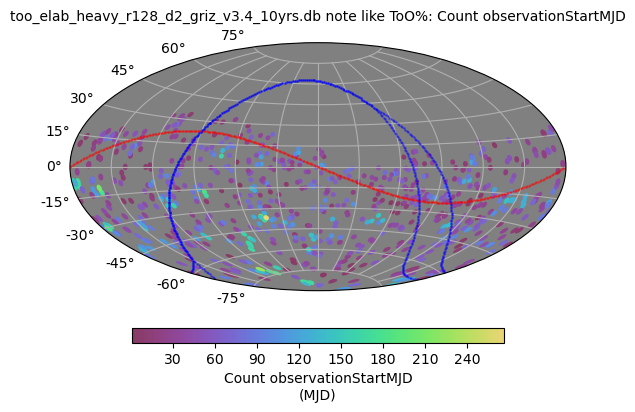

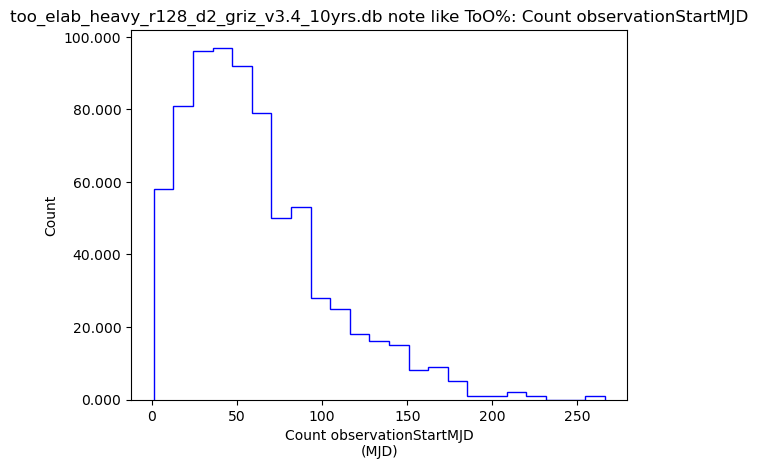

In [201]:
too_nvisits.plot()

In [202]:
df = pd.DataFrame([slicer.slice_points['too_trigger'], 
              slicer.slice_points['peak_time'],
              slicer.slice_points['distance'],
              score_p.metric_values.filled(-999),
                  too_nvisits.metric_values.filled(0)],
            index=['too_trigger', 'peak_time', 'distance', 'score_p', 'nvisits']).T
df

,too_trigger,peak_time,distance,score_p,nvisits
0,0.0,60812.918464,232.164655,0.0,67.0
1,1.0,60814.487435,239.863669,1.0,32.0
2,2.0,60816.169533,243.148398,-999.0,0.0
3,3.0,60819.324396,267.607231,-999.0,0.0
4,4.0,60821.392657,294.350099,-999.0,0.0
...,...,...,...,...,...
1275,1275.0,64436.216047,273.696238,-999.0,0.0
1276,1276.0,64437.083205,119.339973,0.0,45.0
1277,1277.0,64437.997237,214.712743,-999.0,0.0
1278,1278.0,64440.954339,247.562753,-999.0,0.0


In [204]:
observed = df.query('score_p > -1')
observed

,too_trigger,peak_time,distance,score_p,nvisits
0,0.0,60812.918464,232.164655,0.000000,67.0
1,1.0,60814.487435,239.863669,1.000000,32.0
10,10.0,60840.394219,247.308535,0.663423,36.0
11,11.0,60843.489526,270.272615,0.000000,35.0
13,13.0,60848.572217,225.762363,1.000000,123.0
...,...,...,...,...,...
1271,1271.0,64413.820031,252.178169,0.000000,113.0
1272,1272.0,64416.243407,268.719406,0.000000,42.0
1274,1274.0,64429.900822,219.238589,0.000000,36.0
1276,1276.0,64437.083205,119.339973,0.000000,45.0


In [208]:
# so yes -- we're grabbing more than just the specific ToO observations. 
# Need to either modify the metric or modify the slicer to reject additional (late) observations.
too_notes.metric_values[0]

array([(-35.10300495, 223.89272264, 328.51276413, 64191.06456757, 'ToO, 1182_t1', 'ToO 1182'),
       (-35.10300495, 223.89272264, 328.57852905, 64191.06415091, 'ToO, 1182_t1', 'ToO 1182'),
       (-35.10300495, 223.89272264, 328.64434496, 64191.06373424, 'ToO, 1182_t1', 'ToO 1182'),
       (-35.10300495, 223.89272264, 328.71875861, 64191.06331757, 'ToO, 1182_t1', 'ToO 1182'),
       (-35.10300495, 223.89272264, 339.62070242, 64191.00260191, 'ToO, 1182_t1', 'ToO 1182'),
       (-35.10300495, 223.89272264, 322.22473052, 64191.10522283, 'ToO, 1182_t2', 'ToO 1182'),
       (-35.10300495, 223.89272264, 333.82795316, 64191.03243956, 'ToO, 1182_t1', 'ToO 1182'),
       (-36.33058582, 224.48504927, 277.36873095, 63337.30240504, 'ToO, 886_t1', 'ToO 886'),
       (-35.10300495, 223.89272264, 333.742332  , 64191.03285622, 'ToO, 1182_t1', 'ToO 1182'),
       (-35.10300495, 223.89272264, 333.66941805, 64191.03327289, 'ToO, 1182_t1', 'ToO 1182'),
       (-35.10300495, 223.89272264, 333.59665661, 64